# Tutorial 6.2: Dynamics of a Decision-Making Circuit in Two Modes of Operation
## Neuroscience goals: 
- see how noise can lead to significant trial-to-trial variability in behavior
- compare the behavior of an integrator circuit with state-transition circuit
## Computational goals:
- simulate coupled firing-rate units with different types of noise
- record event times and realign vectors with different event times and pad them for further analysis

### Overview
- will produce decision-making circuit and study response to inputs
    - circuit will contain two units (*i*=1, 2)
    - when one of the units reaches decision-threshold, assume one of two alternatives has been chosen
- will switch mode of decision making by altering connection strengths and thresholds of the units
- firing-rate curve of units must be linear function of inputs to be perfect integrator

    $\tau\frac{dr_i}{dt} = -r_i + I_i - \Theta$

    - with constraint $0 \le r_i \le r_{max}$
    - $\Theta$ is firing-threshold (not decision threshold)
    - $I_i$ is input to unit $i$ given by:

        $I_i(t) = W_s \cdot r_i(t) + W_x \cdot r_j(t) + G\cdot s_i(t) + \sigma_{int} \cdot \eta_i (t) $

        - where $r_j(t)$ is rate of other cell (so if i=1, then j=2 and if i=2, then j=1)

    - each unit will receive independent internal noise of strength $\sigma_{int}$
    - and a scalable independent noise within the stimulus $s_i(t)$ of strength $\sigma_s$

- speed-accuracy tradeoff is achieved by altering $G$, which scales input sunapses to circuit
    - stimuli, when present, are given by 
    
        $s_1(t) = \bar s + \Delta s / 2 + \sigma_s \cdot \eta'_1 (t)$ 
        and
        $s_2(t) = \bar s - \Delta s / 2 + \sigma_s \cdot \eta'_2 (t)$ 

        with mean $\bar s = 1$ and variable difference $\Delta s$

    - terms $\eta_1(t), \eta_2(t), \eta'_1(t), \eta'_2(t)$ each represent unit variance noise to be generated independently on each trial

- for integration mode: 
    - $W_s = 0.975, W_x = -0.025, \Theta = -0.5$ for each unit

- for jumping mode:
    - $W_s = 1.05, W_x = -0.05, \Theta = 4 $ for each unit

- for both circuits, set decision threshold of 50 Hz and $r_{max} = 60$ Hz

- in all simulations, simulate until threshold is reached by one of the units or max time of 10s is reached
- use time constant $\tau = 10ms$

### Answer all questions with integration mode, then repeat all with jumping omde






### 1. simulate a single trial without noise:
- initialize firing rates of two units to their identical steady state value in the absence of a stimulus/noise by solving for $r$ in

    $\tau \frac{dr}{dt} = -r + W_s \cdot r + W_x\cdot r - \Theta = 0$

    - enforcing bounds on the range of allowed values of $r$

- in integration mode: G=1
- in jumping mode: G=2.5

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# set parameters
decision_thresh = 50
r_max = 60
tau = 10e-3

params_integration = {
    'ws': 0.975,
    'wx': -0.025,
    'theta': -0.5
    }

params_jumping = {
    'ws': 1.05,
    'wx': -0.05,
    'theta': 4
    }

# calculate firing rate
def dr_dt(r, input, theta, tau=tau):
    return (-r + input - theta) / tau

# calculate input 
def get_input(ws, wx, ri, rj, G, si, sigma_int, eta):
    return ws*ri + wx*rj + G*si + ((sigma_int*eta)/np.sqrt(0.002))

# steady state firing with no inputs/noise
def get_steady_state_r(theta, ws, wx):
    r_steady = theta / (1 - ws - wx)
    return np.clip(r_steady, 0, r_max)

r_steady_int = get_steady_state_r(params_integration['theta'], params_integration['ws'], params_integration['wx'])
r_steady_jump = get_steady_state_r(params_jumping['theta'], params_jumping['ws'], params_jumping['wx'])

print(r_steady_int, r_steady_jump)

g_int = 1
g_jump = 2.5

0.0 0.0


### 1b
- set $\Delta s$ = 0.1 for stimulus commencing at 0.5s and remining on
- simulate differential equations with a timestep of 0.5ms
- plot firing rate of both units as function of time
- separately plot difference in firing rates

In [3]:
# set parameters
dt = 0.5e-3
t = np.arange(0, 10, dt)
stim_start = 0.5
delta_s = 0.1

# initialize variables
s1 = np.zeros_like(t)
s2 = np.zeros_like(t)
s1[t >= stim_start] = 1 + delta_s / 2
s2[t >= stim_start] = 1 - delta_s / 2
r1 = np.zeros_like(t)
r2 = np.zeros_like(t)

In [5]:
def run_trial(params, G, r1, r2, s1, s2, t, dt, sigma_int=0):

    theta = params['theta']
    ws = params['ws']
    wx = params['wx']

    # initialize firing rates
    r_steady = get_steady_state_r(theta, ws, wx)
    r1[0] = r_steady
    r2[0] = r_steady

    for i in range(1, len(t)):
        if i % 2 != 0:
            # get noise
            eta1 = np.random.normal(0, 1)
            eta2 = np.random.normal(0, 1)
        
        # get input for each unit
        input1 = get_input(ws, wx, r1[i - 1], r2[i - 1], G, s1[i - 1], sigma_int, eta1)
        input2 = get_input(ws, wx, r2[i - 1], r1[i - 1], G, s2[i - 1], sigma_int, eta2)

        # update firing rate for each
        r1[i] = r1[i - 1] + dt * dr_dt(r1[i - 1], input1, theta)
        r2[i] = r2[i - 1] + dt * dr_dt(r2[i - 1], input2, theta)

        # enforce bounds
        r1[i] = np.clip(r1[i], 0, r_max)
        r2[i] = np.clip(r2[i], 0, r_max)

        if r1[i] >= decision_thresh or r2[i] >= decision_thresh:
            break
    
    return r1, r2

### as integrator
unit 1 always wins because s1 is > s2
linear increase over time is accumulation of evidence 

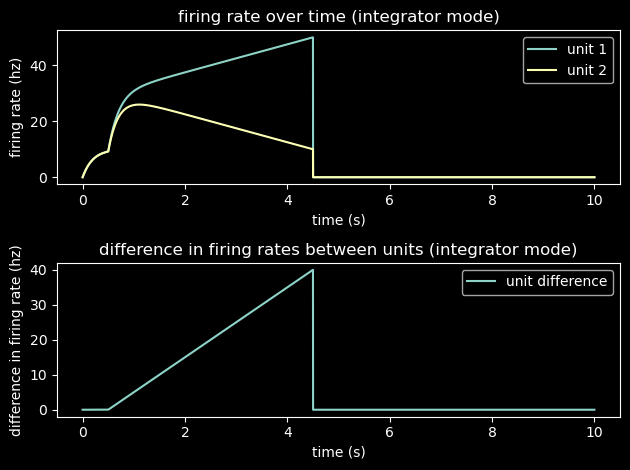

In [39]:
r1 = np.zeros_like(t)
r2 = np.zeros_like(t)
r1_int, r2_int = run_trial(params_integration, g_int, r1, r2, s1, s2, t, dt)

plt.subplot(2, 1, 1)
plt.plot(t, r1_int, label='unit 1')
plt.plot(t, r2_int, label='unit 2')
plt.xlabel('time (s)')
plt.ylabel('firing rate (hz)')
plt.title('firing rate over time (integrator mode)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t, r1_int - r2_int, label='unit difference')
plt.xlabel('time (s)')
plt.ylabel('difference in firing rate (hz)')
plt.title('difference in firing rates between units (integrator mode)')
plt.legend()
plt.tight_layout()

### as jumper
all units remain at 0, possibly on purpose?
- showing non-behavior at low stimulus levels (or sufficiently high threshold)
- scaling s1 or s2 creates a decision

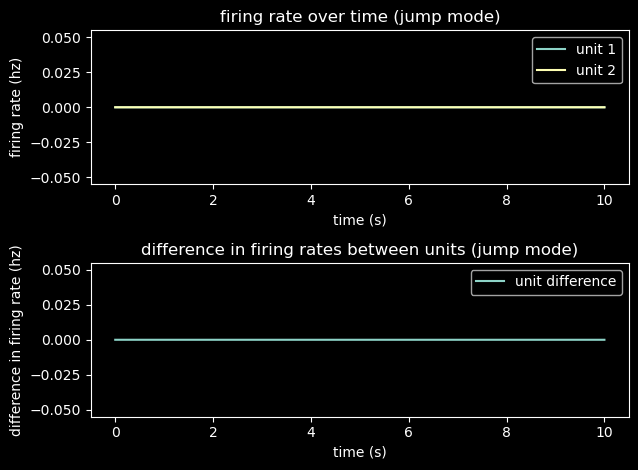

In [37]:
r1 = np.zeros_like(t)
r2 = np.zeros_like(t)
r1_jump, r2_jump = run_trial(params_jumping, g_jump, r1, r2, s1, s2, t, dt)

plt.subplot(2, 1, 1)
plt.plot(t, r1_jump, label='unit 1')
plt.plot(t, r2_jump, label='unit 2')
plt.xlabel('time (s)')
plt.ylabel('firing rate (hz)')
plt.title('firing rate over time (jump mode)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t, r1_jump - r2_jump, label='unit difference')
plt.xlabel('time (s)')
plt.ylabel('difference in firing rate (hz)')
plt.title('difference in firing rates between units (jump mode)')
plt.legend()
plt.tight_layout()

### 2. add noise
- add independent noise to the entire duration of each stimulus
    - repeatedly choose two random numbers (one for each stimulus) from unit gaussian distribution (randn() in matlab)
    - keep noise values fixed for each 2ms of the stimulus duration
- multiply each noise value by $\sigma_s$ = 0.2 and divide by `np.sqrt(0.002)` before adding to stimulus
- add intrinsic noise in a similar manner, keeping fixed every 2ms, and use magnitude $\sigma_s$ = 0.25
    - ensure intrinsic noise is present across all of the time stimulated (not just during stimulus)
- simulate 200 trials, and for each trial record firing rate as function of time

In [42]:
# add noise
noise1 = np.zeros_like(t)
noise2 = np.zeros_like(t)
for i in range(len(t)):
    if i % 2 == 0:
        noise1[i] = np.random.normal(0, 1)
        noise2[i] = np.random.normal(0, 1)
    else: 
        noise1[i] = noise1[i - 1]
        noise2[i] = noise2[i - 1]

### as integrator

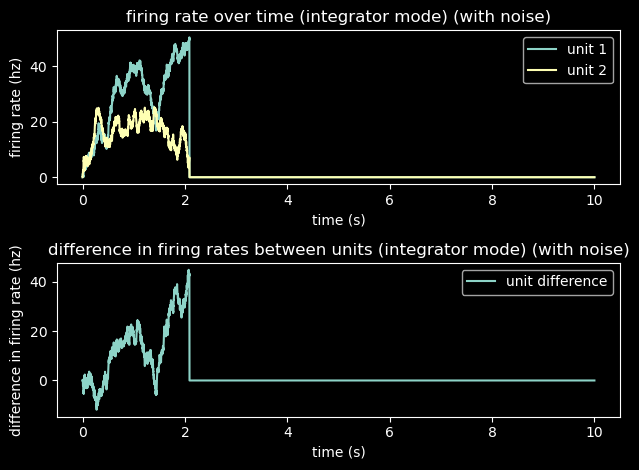

In [41]:
r1 = np.zeros_like(t)
r2 = np.zeros_like(t)
r1_int, r2_int = run_trial(params_integration, g_int, r1, r2, s1, s2, t, dt, sigma_int=0.2)


plt.subplot(2, 1, 1)
plt.plot(t, r1_int, label='unit 1')
plt.plot(t, r2_int, label='unit 2')
plt.xlabel('time (s)')
plt.ylabel('firing rate (hz)')
plt.title('firing rate over time (integrator mode) (with noise)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t, r1_int - r2_int, label='unit difference')
plt.xlabel('time (s)')
plt.ylabel('difference in firing rate (hz)')
plt.title('difference in firing rates between units (integrator mode) (with noise)')
plt.legend()
plt.tight_layout()

### as jumper 

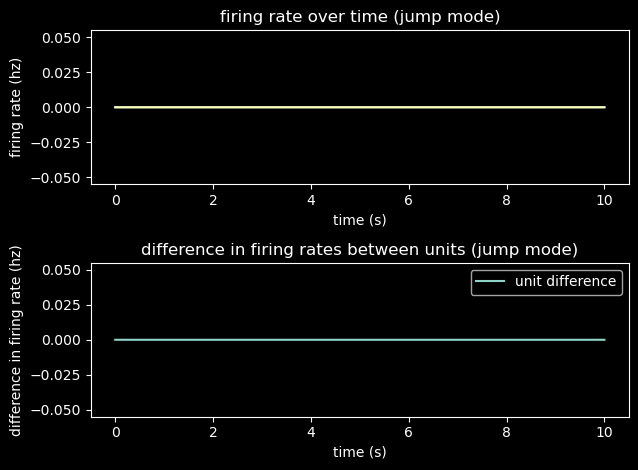

In [52]:
r1 = np.zeros_like(t)
r2 = np.zeros_like(t)
r1_int, r2_int = run_trial(params_jumping, g_jump, r1, r2, s1, s2, t, dt, sigma_int=0.2)


plt.subplot(2, 1, 1)
plt.plot(t, r1_jump, label='unit 1')
plt.plot(t, r2_jump, label='unit 2')
plt.xlabel('time (s)')
plt.ylabel('firing rate (hz)')
plt.title('firing rate over time (jump mode)')

plt.subplot(2, 1, 2)
plt.plot(t, r1_jump - r2_jump, label='unit difference')
plt.xlabel('time (s)')
plt.ylabel('difference in firing rate (hz)')
plt.title('difference in firing rates between units (jump mode)')
plt.legend()
plt.tight_layout()

## record 200 times
## 2a. 
- plot mean firing rate aligned to stimulus onset for both units
- be careful to include in the across-trial average at each time point only those trials yet to produce a threshold-crossing
### as integrator

In [67]:
# run 200 trials
r1_array_int = np.zeros((200, len(t)))
r2_array_int = np.zeros((200, len(t)))
for i in range(200):
    r1 = np.zeros_like(t)
    r2 = np.zeros_like(t)
    r1_int, r2_int = run_trial(params_integration, g_int, r1, r2, s1, s2, t, dt, sigma_int=0.2)
    r1_array_int[i] = r1_int
    r2_array_int[i] = r2_int

In [74]:
def filter_trials(data):
    # trials where neither unit reached the decision threshold
    valid_trials = np.all(data < decision_thresh, axis=1)
    # keep shape by returning all data points, but only valid trials
    return data[valid_trials]

r1_filtered = filter_trials(r1_array_int)
r2_filtered = filter_trials(r2_array_int)

# get mean 
mean_r1_filtered = np.mean(r1_filtered, axis=0)
mean_r2_filtered = np.mean(r2_filtered, axis=0)


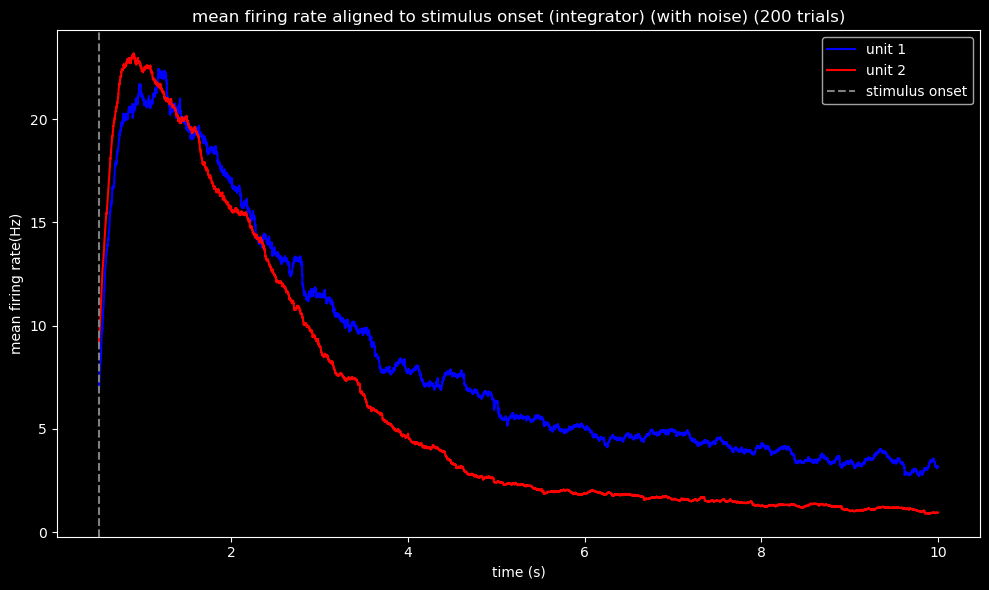

In [77]:
plt.figure(figsize=(10,6))

# stimulus onset
stimulus_onset_idx = int(stim_start / dt)

# plot
plt.plot(t[stimulus_onset_idx:], mean_r1_filtered[stimulus_onset_idx:], label='unit 1', color='blue')
plt.plot(t[stimulus_onset_idx:], mean_r2_filtered[stimulus_onset_idx:], label='unit 2', color='red')
plt.axvline(x=stim_start, color='grey', linestyle='--', label='stimulus onset')
plt.xlabel('time (s)')
plt.ylabel('mean firing rate(Hz)')
plt.title('mean firing rate aligned to stimulus onset (integrator) (with noise) (200 trials)')
plt.legend()
plt.tight_layout()
plt.show()


### as jumper

In [78]:
r1_array_jump = np.zeros((200, len(t)))
r2_array_jump = np.zeros((200, len(t)))
for i in range(200):
    r1 = np.zeros_like(t)
    r2 = np.zeros_like(t)
    r1_jump, r2_jump = run_trial(params_jumping, g_jump, r1, r2, s1, s2, t, dt, sigma_int=0.2)
    r1_array_jump[i] = r1_jump
    r2_array_jump[i] = r2_jump

In [81]:
r1_filtered = filter_trials(r1_array_jump)
r2_filtered = filter_trials(r2_array_jump)

# get mean 
mean_r1_filtered = np.mean(r1_filtered, axis=0)
mean_r2_filtered = np.mean(r2_filtered, axis=0)

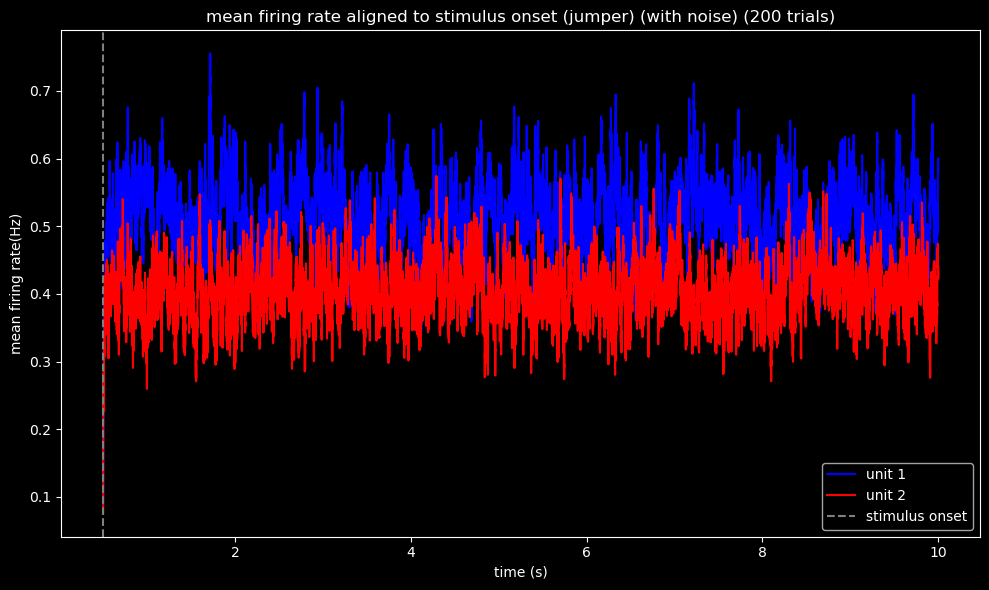

In [83]:
plt.figure(figsize=(10,6))

# stimulus onset
stimulus_onset_idx = int(stim_start / dt)

# plot
plt.plot(t[stimulus_onset_idx:], mean_r1_filtered[stimulus_onset_idx:], label='unit 1', color='blue')
plt.plot(t[stimulus_onset_idx:], mean_r2_filtered[stimulus_onset_idx:], label='unit 2', color='red')
plt.axvline(x=stim_start, color='grey', linestyle='--', label='stimulus onset')
plt.xlabel('time (s)')
plt.ylabel('mean firing rate(Hz)')
plt.title('mean firing rate aligned to stimulus onset (jumper) (with noise) (200 trials)')
plt.legend()
plt.tight_layout()
plt.show()


### 2b
- plot mean firing rate during decision-making period, aligning across trials to the time of decision-threshold crossing
- be careful to either include at each time point only those trials being simulated at that time point
    - or set rates to initial firing-rate value at all time points before the simulation started
    - this is necessary, since firing-rate arrays for each trial will be offset from each other by large amounts according to the range of threshold-crossing times

### define functions

In [87]:
# determine threshold-crossing times for each trial

def find_threshold_crossing_times(r1_array, r2_array, decision_thresh):
    crossing_times = []
    # loop through firing rate time array
    for i in range(r1_array.shape[0]):
        # time when either unit crosses decision thresh
        crossing_time = np.where((r1_array[i] >= decision_thresh) | (r2_array[i] >= decision_thresh))[0]
        if len(crossing_time) > 0:
            crossing_times.append(crossing_time[0])
        else:
            # default to last index if no crossing
            crossing_times.append(len(r1_array[i]))

    return np.asarray(crossing_times)

# align firing rates to threshold-crossing times

def align_to_thresh(r_array, crossing_times, pre_samples=1000, post_samples=1000):
    aligned_data = np.zeros((len(crossing_times), pre_samples+post_samples))

    for i, crossing_time in enumerate(crossing_times):
        # get indices 
        pre_start = max(0, crossing_time - pre_samples)
        post_end = min(len(r_array[i]), crossing_time + post_samples)
        # data before and after crossing threshold
        pre_data = r_array[i, pre_start:crossing_time]
        post_data = r_array[i, crossing_time:post_end]
        # align around threshold crossing index
        aligned_data[i, -len(pre_data):] = pre_data
        aligned_data[i, pre_samples:pre_samples + len(post_data)] = post_data
    
    return aligned_data


### as integrator

In [88]:
crossing_times_int = find_threshold_crossing_times(r1_array_int, r2_array_int, decision_thresh)
aligned_r1_int = align_to_thresh(r1_array_int, crossing_times_int)
aligned_r2_int = align_to_thresh(r2_array_int, crossing_times_int)

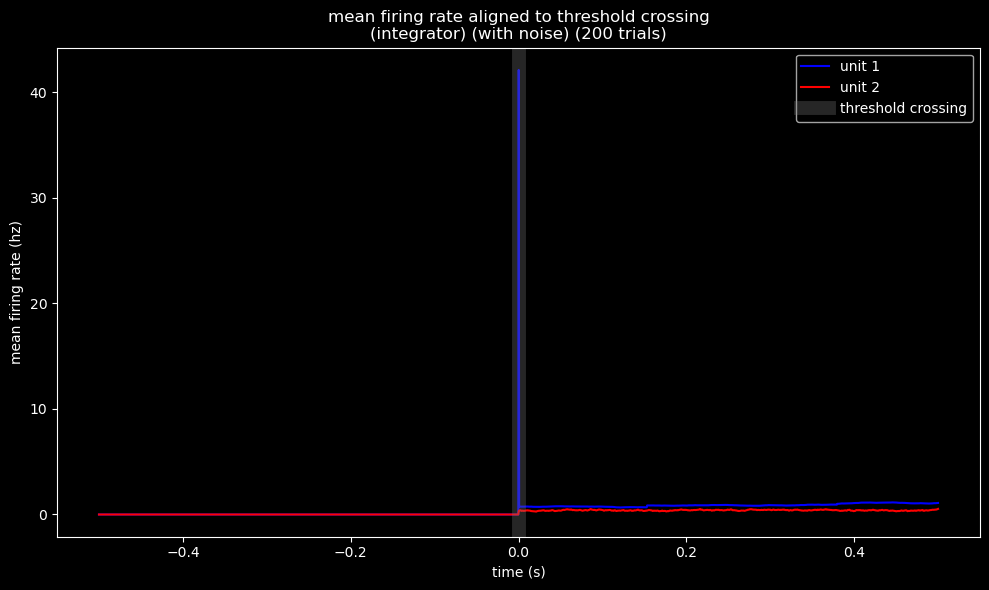

In [98]:
pre_samples = 1000
post_samples = 1000
aligned_time = np.linspace(-pre_samples * dt, post_samples * dt, pre_samples+post_samples)

plt.figure(figsize=(10, 6))
plt.plot(aligned_time, np.mean(aligned_r1_int, axis=0), label='unit 1', color='b')
plt.plot(aligned_time, np.mean(aligned_r2_int, axis=0), label='unit 2', color='r')
plt.axvline(x=0, color='gray', linestyle='-', label='threshold crossing', alpha=0.3, linewidth=10)
plt.xlabel('time (s)')
plt.ylabel('mean firing rate (hz)')
plt.title('mean firing rate aligned to threshold crossing\n(integrator) (with noise) (200 trials)')
plt.legend()
plt.tight_layout()

### as jumper

In [99]:
crossing_times_jump = find_threshold_crossing_times(r1_array_jump, r2_array_jump, decision_thresh)
aligned_r1_jump = align_to_thresh(r1_array_jump, crossing_times_jump)
aligned_r2_jump = align_to_thresh(r2_array_jump, crossing_times_int)

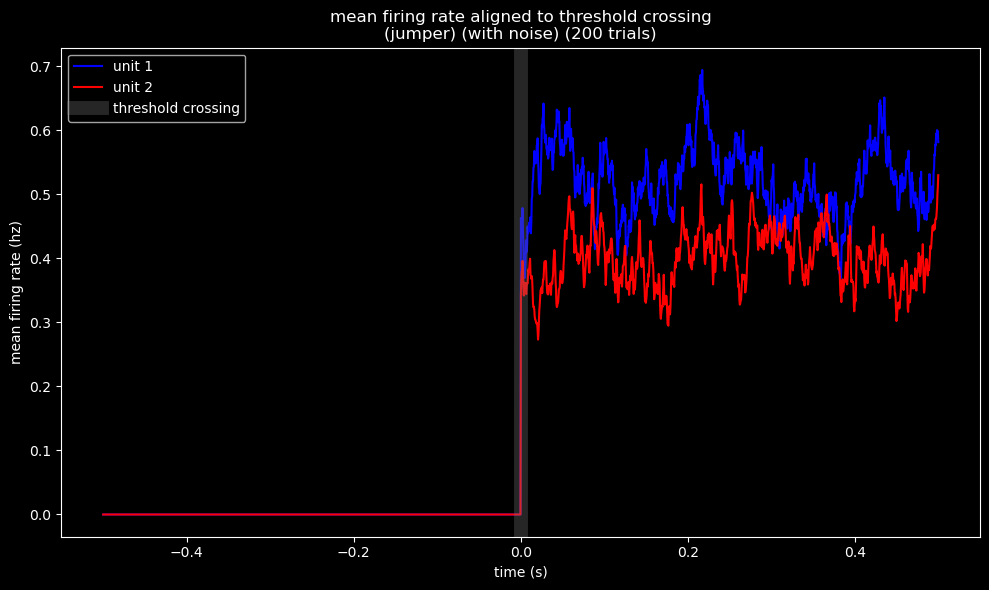

In [100]:
pre_samples = 1000
post_samples = 1000
aligned_time = np.linspace(-pre_samples * dt, post_samples * dt, pre_samples+post_samples)

plt.figure(figsize=(10, 6))
plt.plot(aligned_time, np.mean(aligned_r1_jump, axis=0), label='unit 1', color='b')
plt.plot(aligned_time, np.mean(aligned_r2_jump, axis=0), label='unit 2', color='r')
plt.axvline(x=0, color='gray', linestyle='-', label='threshold crossing', alpha=0.3, linewidth=10)
plt.xlabel('time (s)')
plt.ylabel('mean firing rate (hz)')
plt.title('mean firing rate aligned to threshold crossing\n(jumper) (with noise) (200 trials)')
plt.legend()
plt.tight_layout()

### 2c.
- record which unit first crosses the decision threshold, and the time of threshold-crossing
- plot a histogram of the times to threshold on trials for which unit 1 (which received greater input) was the first to reach threshold

### as integrator 

In [101]:
# record which unit crosses threshold first and crossing time

def find_first_crossing_unit(r1_array, r2_array, decision_thresh):
    first_units = []

    for i in range(r1_array.shape[0]):
        r1_cross = np.where(r1_array[i] >= decision_thresh)[0]
        r2_cross = np.where(r2_array[i] >= decision_thresh)[0]

        if len(r1_cross) > 0 and (len(r2_cross) == 0 or r1_cross[0] < r2_cross[0]):
            first_units.append(1)
        elif len(r2_cross) > 0 and (len(r1_cross) == 0 or r2_cross[0] < r1_cross[0]):
            first_units.append(2)
        else:
            first_units.append(0)
    return first_units


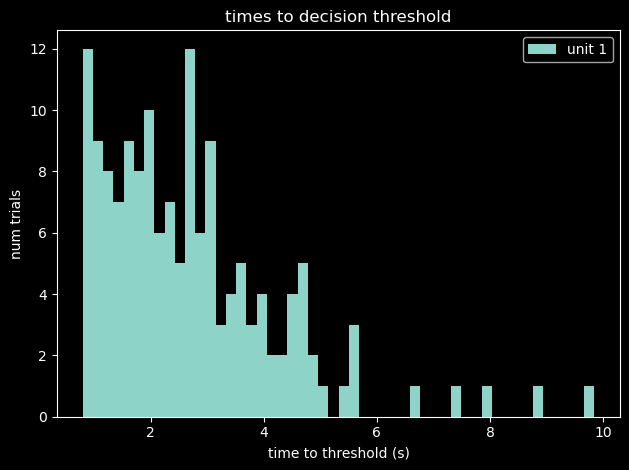

In [105]:
first_units_int = find_first_crossing_unit(r1_array_int, r2_array_int, decision_thresh)
unit1_crossing_times_int = [crossing_times_int[i] for i in range(len(first_units_int)) if first_units_int[i] == 1]
unit2_crossing_times_int = [crossing_times_int[i] for i in range(len(first_units_int)) if first_units_int[i] == 2]

plt.hist(np.asarray(unit1_crossing_times_int) * dt, bins=50, label='unit 1')
plt.xlabel('time to threshold (s)')
plt.ylabel('num trials')
plt.title('times to decision threshold')
plt.legend()
plt.tight_layout()

### as jumper

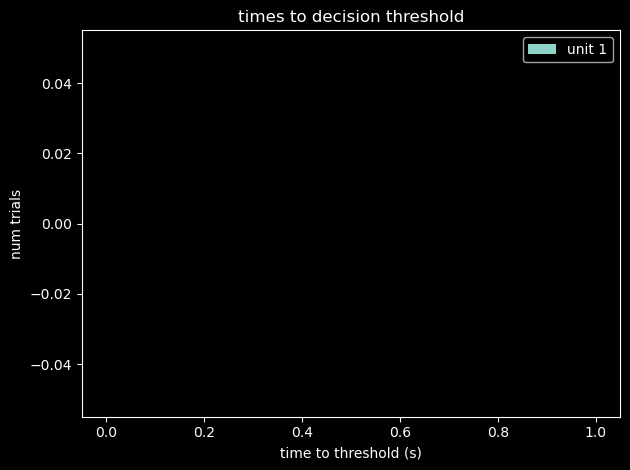

In [106]:
first_units_jump = find_first_crossing_unit(r1_array_jump, r2_array_jump, decision_thresh)
unit1_crossing_times_jump = [crossing_times_int[i] for i in range(len(first_units_jump)) if first_units_jump[i] == 1]
unit2_crossing_times_jump = [crossing_times_int[i] for i in range(len(first_units_jump)) if first_units_jump[i] == 2]

plt.hist(np.asarray(unit1_crossing_times_jump) * dt, bins=50, label='unit 1')
plt.xlabel('time to threshold (s)')
plt.ylabel('num trials')
plt.title('times to decision threshold')
plt.legend()
plt.tight_layout()

### 3
- repeat 2c, looping through values of $\Delta s$ = 0, 0.25, 0.5, 0.75, 1
- record mean time for unit 1 to reach threshold (when it does) as well as fraction of trials in which unit 1 is the winner for each value of $\Delta s$
- plot these two quantities separately against stimulus difference, $\Delta s$


In [107]:
# set parameters
dt = 0.5e-3
t = np.arange(0, 10, dt)
stim_start = 0.5
delta_s = 0.1

# initialize variables
s1 = np.zeros_like(t)
s2 = np.zeros_like(t)
s1[t >= stim_start] = 1 + delta_s / 2
s2[t >= stim_start] = 1 - delta_s / 2
r1 = np.zeros_like(t)
r2 = np.zeros_like(t)

In [114]:
delta_s_vals = np.arange(0, 1.1, 0.25)
mean_times_int = []
mean_times_jump = []
winning_fractions_int = []
winning_fractions_jump = []

for delta_s in delta_s_vals:

    # modify stimulus intensity
    s1[t >= stim_start] = 1 + delta_s / 2
    s2[t >= stim_start] = 1 - delta_s / 2

    r1_array_int = np.zeros((200, len(t)))
    r2_array_int = np.zeros((200, len(t)))
    r1_array_jump = np.zeros((200, len(t)))
    r2_array_jump = np.zeros((200, len(t)))

    # simulate 200 
    for i in range(200):
        r1 = np.zeros_like(t)
        r2 = np.zeros_like(t)
        # integrator and jumper
        r1_int, r2_int = run_trial(params_integration, g_int, r1, r2, s1, s2, t, dt, sigma_int=0.2)
        r1_jump, r2_jump = run_trial(params_jumping, g_jump, r1, r2, s1, s2, t, dt, sigma_int=0.2)
        # integrator
        r1_array_int[i] = r1_int
        r2_array_int[i] = r2_int
        # jumper
        r1_array_jump[i] = r1_jump
        r2_array_jump[i] = r2_jump

    crossing_times_int = find_threshold_crossing_times(r1_array_int, r2_array_int, decision_thresh)
    first_units_int = find_first_crossing_unit(r1_array_int, r2_array_int, decision_thresh)
    unit1_crossing_times_int = [crossing_times_int[i] for i in range(len(first_units_int)) if first_units_int[i] == 1]

    crossing_times_jump = find_threshold_crossing_times(r1_array_jump, r2_array_jump, decision_thresh)
    first_units_jump = find_first_crossing_unit(r1_array_jump, r2_array_jump, decision_thresh)
    unit1_crossing_times_jump = [crossing_times_jump[i] for i in range(len(first_units_jump)) if first_units_jump[i] == 1]

    # compute and store mean crossing time or unit 1 and fraction of trials 'won'
    if len(unit1_crossing_times_int) > 0:
        mean_times_int.append(np.mean(np.array(unit1_crossing_times_int) * dt))
    else:
        mean_times_int.append(np.nan)

    if len(unit1_crossing_times_jump) > 0:
        mean_times_jump.append(np.mean(np.array(unit1_crossing_times_jump) * dt))
    else:
        mean_times_jump.append(np.nan)
    
    winning_fractions_int.append(first_units_int.count(1) / len(first_units_int))
    winning_fractions_int.append(first_units_jump.count(1) / len(first_units_jump))

### plot integrator

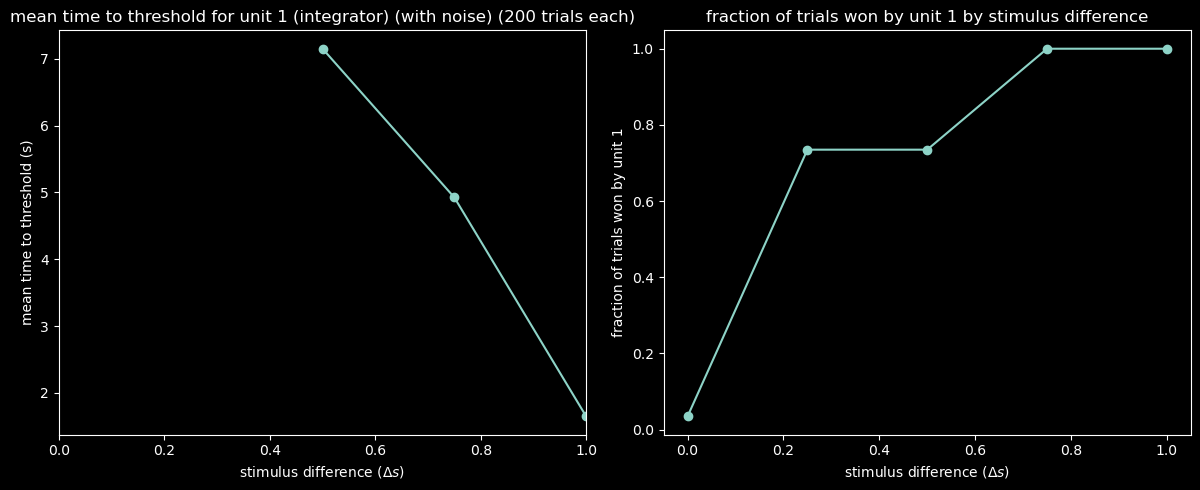

In [128]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(delta_s_vals, mean_times_int, 'o-',)
plt.xlabel('stimulus difference ($\Delta s$)')
plt.xlim(0, 1)
plt.ylabel('mean time to threshold (s)')
plt.title('mean time to threshold for unit 1 (integrator) (with noise) (200 trials each)')

plt.subplot(1, 2, 2)
plt.plot(delta_s_vals, winning_fractions_int[5:], 'o-')
plt.xlabel('stimulus difference ($\Delta s$)')
plt.ylabel('fraction of trials won by unit 1')
plt.title('fraction of trials won by unit 1 per stimulus difference')

plt.tight_layout()

### plot jumper

Text(0.5, 1.0, 'fraction of trials won by unit 1 by stimulus difference')

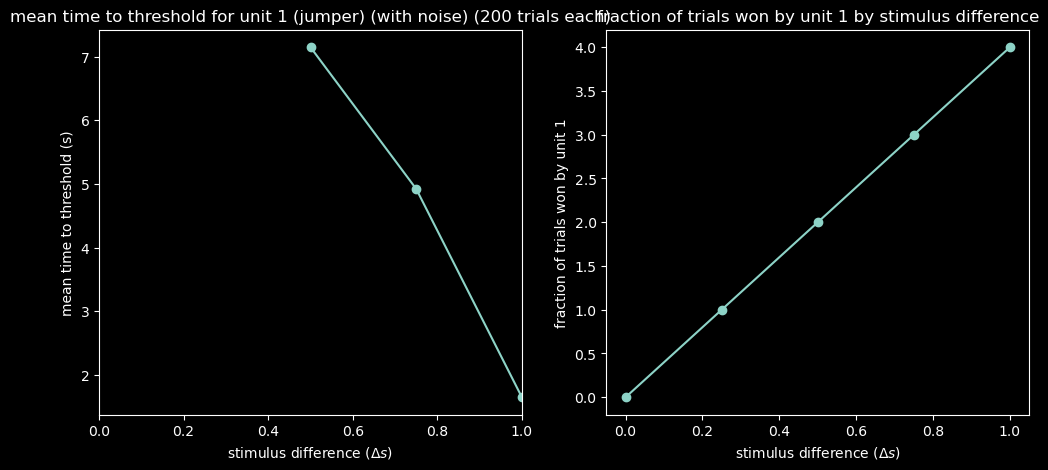

In [136]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(delta_s_vals, mean_times_jump, 'o-',)
plt.xlabel('stimulus difference ($\Delta s$)')
plt.ylabel('mean time to threshold (s)')
plt.title('mean time to threshold for unit 1 (jumper) (with noise) (200 trials each)')
plt.xlim(0, 1)

plt.subplot(1, 2, 2)
plt.plot(delta_s_vals, winning_fractions_jump, 'o-')
plt.xlabel('stimulus difference ($\Delta s$)')
plt.ylabel('fraction of trials won by unit 1')
plt.title('fraction of trials won by unit 1 by stimulus difference')

# 4.
- repeat 1-3 with g_int = 0.5, g_jump = 2

In [141]:
# params
configs = [
    {'g_int': 1, 'g_jump': 2.5, 'delta_s_vals': [0, 0.25, 0.5, 0.75, 1]},
    {'g_int': 0.5, 'g_jump': 2, 'delta_s_vals': [0, 0.25, 0.5, 0.75, 1]}
]

In [151]:
# simulate trials, both integrator and jumper

def simulate_trials(config):
    mean_times_int = []
    mean_times_jump = []
    winning_fractions_int = []
    winning_fractions_jump = []

    g_int = config['g_int']
    g_jump = config['g_jump']
    delta_s_vals = config['delta_s_vals']

    for delta_s in delta_s_vals:
       # modify stimulus intensity
        s1[t >= stim_start] = 1 + delta_s / 2
        s2[t >= stim_start] = 1 - delta_s / 2

        r1_array_int = np.zeros((200, len(t)))
        r2_array_int = np.zeros((200, len(t)))
        r1_array_jump = np.zeros((200, len(t)))
        r2_array_jump = np.zeros((200, len(t)))

        # simulate 200 
        for i in range(200):
            r1 = np.zeros_like(t)
            r2 = np.zeros_like(t)
            # integrator and jumper
            r1_int, r2_int = run_trial(params_integration, g_int, r1, r2, s1, s2, t, dt, sigma_int=0.2)
            r1_jump, r2_jump = run_trial(params_jumping, g_jump, r1, r2, s1, s2, t, dt, sigma_int=0.2)
            # integrator
            r1_array_int[i] = r1_int
            r2_array_int[i] = r2_int
            # jumper
            r1_array_jump[i] = r1_jump
            r2_array_jump[i] = r2_jump

        crossing_times_int = find_threshold_crossing_times(r1_array_int, r2_array_int, decision_thresh)
        first_units_int = find_first_crossing_unit(r1_array_int, r2_array_int, decision_thresh)
        unit1_crossing_times_int = [crossing_times_int[i] for i in range(len(first_units_int)) if first_units_int[i] == 1]

        crossing_times_jump = find_threshold_crossing_times(r1_array_jump, r2_array_jump, decision_thresh)
        first_units_jump = find_first_crossing_unit(r1_array_jump, r2_array_jump, decision_thresh)
        unit1_crossing_times_jump = [crossing_times_jump[i] for i in range(len(first_units_jump)) if first_units_jump[i] == 1]

        # compute and store mean crossing time or unit 1 and fraction of trials 'won'
        if len(unit1_crossing_times_int) > 0:
            mean_times_int.append(np.mean(np.array(unit1_crossing_times_int) * dt))
        else:
            mean_times_int.append(np.nan)

        if len(unit1_crossing_times_jump) > 0:
            mean_times_jump.append(np.mean(np.array(unit1_crossing_times_jump) * dt))
        else:
            mean_times_jump.append(np.nan)
        
        winning_fractions_int.append(first_units_int.count(1) / len(first_units_int))
        winning_fractions_jump.append(first_units_jump.count(1) / len(first_units_jump))

    return mean_times_int, winning_fractions_int, mean_times_jump, winning_fractions_jump

# plot all results
def plot_all_results(delta_s_vals, mean_times_int, winning_fractions_int, mean_times_jump, winning_fractions_jump):
    fig, ax = plt.subplots(2, 2, figsize=(12, 12))

    ax[0][0].plot(delta_s_vals, mean_times_int, 'o-')
    ax[0][0].set_xlabel('stimulus difference ($\Delta s$)')
    ax[0][0].set_ylabel('mean time to threshold (s)')
    ax[0][0].set_xlim(0, 1)
    ax[0][0].set_title('(integrator)\nmean time to thresh for unit 1)')

    ax[0][1].plot(delta_s_vals, winning_fractions_int, 'o-')
    ax[0][1].set_xlabel('stimulus difference ($\Delta s$)')
    ax[0][1].set_xlim(0, 1)
    ax[0][1].set_ylabel('fraction of trials won by unit 1')
    ax[0][1].set_title('(integrator)\nfraction of trials won by unit 1 per stimulus difference')

    ax[1][0].plot(delta_s_vals, mean_times_jump, 'o-')
    ax[1][0].set_xlabel('stimulus difference ($\Delta s$)')
    ax[1][0].set_ylabel('mean time to threshold (s)')
    ax[1][0].set_xlim(0, 1)
    ax[1][0].set_title('(jumper)\nmean time to thresh for unit 1 per stimulus difference')
    
    ax[1][1].plot(delta_s_vals, winning_fractions_jump, 'o-')
    ax[1][1].set_xlabel('stimulus difference ($\Delta s$)')
    ax[1][1].set_ylabel('fraction of trials won by unit 1')
    ax[1][1].set_xlim(0, 1)
    ax[1][1].set_title('(jumper)\nfraction of trials won by unit 1 per stimulus difference')

    plt.tight_layout()
    plt.show()

In [ ]:
for config in configs:
    mean_times_int, winning_fractions_int, mean_times_jump, winning_fractions_jump = simulate_trials(config)
    plot_all_results(config['delta_s_vals'], mean_times_int, winning_fractions_int, mean_times_jump, winning_fractions_jump)
    plt.show()